# Vanilla Policy Gradient (VPG)
adapted implementation of the openai spinning up's VPG. see:
https://github.com/openai/spinningup/blob/master/spinup/examples/pytorch/pg_math/1_simple_pg.py
note:
- "reward to go" is used here
- this notebook is closer to Miguel's REINFORCE implementation
- Miguel's VPG actually uses action-advantage function instead of discounted rewards
- Miguel's VPG can be referenced as REINFORCE with baseline to avoid confusion. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
# !nvidia-smi

using cpu


/home/jim/mambaforge/envs/rl/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# miguel has an image based version, I need to start with a state based one... 
class SimpleModel(nn.Module):

    def __init__(self, in_features, outputs):
        super(SimpleModel, self).__init__()
        self.linear1 = nn.Linear(in_features, 32)
        self.final = nn.Linear(32, outputs)
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             device=self.device,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, x):
        x = self._format(x)
        x = F.relu(self.linear1(x))
        x = self.final(x)
        return x

In [4]:
env = gym.make("CartPole-v1")
n_states = env.observation_space.shape[0]
n_action = env.action_space.n
print("action space:", env.action_space)
print("observation space:", env.observation_space)
observation, info = env.reset(seed=42)
print("observation:", observation)
print("info", info)
model = SimpleModel(n_states, n_action)
model

action space: Discrete(2)
observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
observation: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
info {}


SimpleModel(
  (linear1): Linear(in_features=4, out_features=32, bias=True)
  (final): Linear(in_features=32, out_features=2, bias=True)
)

In [5]:
n_episodes = 500
reward_record = []
avg_record = []
learning_rate = 0.01
gamma=1.00
solved = False
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for episode in range(n_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    episode_rewards = []
    episode_log_p_a = []
    if solved:
        print("solved!")
    while not (terminated or truncated):
        # execute episode
        logits = model.forward(state)
        policy = torch.distributions.Categorical(logits=logits)
        action_tensor = policy.sample()
        log_prob_action = policy.log_prob(action_tensor)
        episode_log_p_a.append(log_prob_action)
        state, reward, terminated, truncated, info = env.step(action_tensor.item())
        episode_rewards.append(reward)
        
    # calculate loss
    T = len(episode_rewards)
    discount_vector = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    returns = []
    for t in range(T):
        returns.append(np.sum(discount_vector[:(T-t)] * episode_rewards[t:]))
        # returns.append(np.sum(episode_rewards[t:]))  # reward to go, no discount
    # multiply by discount optional?
    episode_log_p_a = torch.cat(episode_log_p_a)
    loss = -(episode_log_p_a * torch.tensor(returns)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"episode: {episode}, loss: {loss.item():4.3f}, reward: {np.sum(episode_rewards)}")
    reward_record.append(np.sum(episode_rewards))
    rolling_average = np.mean(reward_record[-100:])
    avg_record.append(rolling_average)

episode: 0, loss: 4.266, reward: 13.0
episode: 1, loss: 3.972, reward: 12.0
episode: 2, loss: 6.533, reward: 17.0
episode: 3, loss: 6.399, reward: 17.0
episode: 4, loss: 10.961, reward: 33.0
episode: 5, loss: 4.696, reward: 14.0
episode: 6, loss: 3.955, reward: 13.0
episode: 7, loss: 14.340, reward: 38.0
episode: 8, loss: 2.296, reward: 9.0
episode: 9, loss: 3.836, reward: 13.0
episode: 10, loss: 10.874, reward: 31.0
episode: 11, loss: 2.516, reward: 9.0
episode: 12, loss: 3.435, reward: 11.0
episode: 13, loss: 3.223, reward: 10.0
episode: 14, loss: 1.796, reward: 10.0
episode: 15, loss: 4.584, reward: 14.0
episode: 16, loss: 6.374, reward: 19.0
episode: 17, loss: 2.545, reward: 10.0
episode: 18, loss: 6.864, reward: 21.0
episode: 19, loss: 6.602, reward: 20.0
episode: 20, loss: 2.663, reward: 12.0
episode: 21, loss: 3.067, reward: 10.0
episode: 22, loss: 4.758, reward: 15.0
episode: 23, loss: 13.118, reward: 36.0
episode: 24, loss: 6.227, reward: 18.0
episode: 25, loss: 2.559, reward:

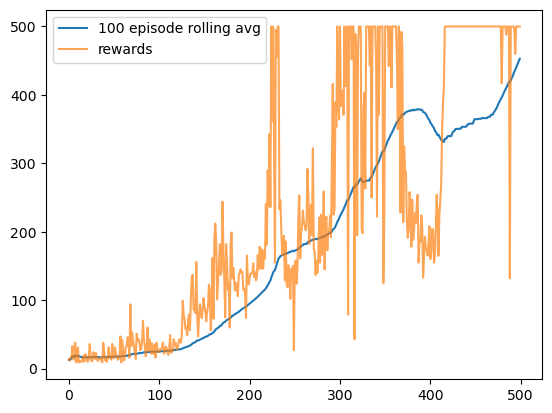

In [6]:
plt.plot(avg_record, label='100 episode rolling avg')
plt.plot(reward_record, alpha=0.7, label='rewards')
plt.legend()

In [7]:
env = gym.make('CartPole-v1', render_mode="human")
state, info = env.reset()
model.eval()
terminated, truncated = False, False
for _ in range(2):
    while not (terminated or truncated):
        logits = model.forward(state)
        policy = torch.distributions.Categorical(logits=logits)
        action_tensor = policy.sample()
        state, reward, terminated, truncated, info = env.step(action_tensor.item())
    observation, info = env.reset()

env.close()

In [191]:
# alternative rewards function from spinning up repo
# I added the discount factor
test_gamma = 0.99
test_discount = np.logspace(0, 5, num=5, base=test_gamma, endpoint=False)
test_rewards = [0.0, 0.0, 0.0, 0.0, 1.0]
def reward_to_go(rews):    
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        i_discount = pow(test_gamma, n - 1 - i)
        rtgs[i] = rews[i] * i_discount + (rtgs[i+1] if i+1 < n else 0)
        print(i, i_discount, rtgs[i])
    return rtgs
reward_to_go(test_rewards)

4 1.0 1.0
3 0.99 1.0
2 0.9801 1.0
1 0.970299 1.0
0 0.96059601 1.0


array([1., 1., 1., 1., 1.])

In [177]:
T = 5
for t in range(T):
    t_discount = test_discount[:(T-t)]
    t_reward = test_rewards[t:]
    print("discount", t_discount)
    print("reward", t_reward)
    print("sum:", t, np.sum( t_discount * t_reward ))

discount [1.         0.99       0.9801     0.970299   0.96059601]
reward [0.0, 0.0, 0.0, 0.0, 1.0]
sum: 0 0.96059601
discount [1.       0.99     0.9801   0.970299]
reward [0.0, 0.0, 0.0, 1.0]
sum: 1 0.970299
discount [1.     0.99   0.9801]
reward [0.0, 0.0, 1.0]
sum: 2 0.9801
discount [1.   0.99]
reward [0.0, 1.0]
sum: 3 0.99
discount [1.]
reward [1.0]
sum: 4 1.0


In [14]:
# side note, showing how torch categorical distributions work
test_distribution = torch.Tensor([0.1, 0.2, 0.3, 0.4])
print("test distribution:", test_distribution)
softmax_distribution = torch.softmax(test_distribution, dim=-1)
print("softmax distribution:", softmax_distribution)
print("---------------------------------------")
print("test distribution as probabilities:")
m = Categorical(probs=test_distribution)
for i in range(4):
    x = torch.Tensor([i])
    print(torch.exp(m.log_prob(x)))
print("test distribution as logits:")
m = Categorical(logits=test_distribution)
for i in range(4):
    x = torch.Tensor([i])
    print(torch.exp(m.log_prob(x)))
print("softmax test distribution as probs:")
m = Categorical(probs=softmax_distribution)
for i in range(4):
    x = torch.Tensor([i])
    print(torch.exp(m.log_prob(x)))

test distribution: tensor([0.1000, 0.2000, 0.3000, 0.4000])
softmax distribution: tensor([0.2138, 0.2363, 0.2612, 0.2887])
---------------------------------------
test distribution as probabilities:
tensor([0.1000])
tensor([0.2000])
tensor([0.3000])
tensor([0.4000])
test distribution as logits:
tensor([0.2138])
tensor([0.2363])
tensor([0.2612])
tensor([0.2887])
softmax test distribution as probs:
tensor([0.2138])
tensor([0.2363])
tensor([0.2612])
tensor([0.2887])
